In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt


# Read data

In [14]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2_def2.parquet')



# Count warnings

In [15]:
df_aih.sum()

co_imed                                                                 17781180169
year_week                         2022-472022-482022-492022-502022-512022-522023...
warning_aih                                                                    2618
n                                                                           1803478
warning_aih_without_isolated                                                   1929
warning_aih_corect_with_consec                                                 2216
warning_final_aih                                                               482
dtype: object

In [16]:
df_aps.out_of_limits_above_phc_only.sum()

13106

In [17]:
df_otc.out_of_limits_above_otc_only.sum()

13066

# Peform analysis only for regions with at least one hospitalization warning

In [18]:
warning_region = df_aih.groupby('co_imed')['warning_final_aih'].sum().reset_index().rename(columns={'warning_final_aih': 'sum_war'})


In [19]:
# Step 3: Merge p50 back to original data
df_aih = df_aih.merge(warning_region, on='co_imed', how='left')

In [20]:
lst = df_aih[df_aih.sum_war == 0].co_imed.unique().astype(list)

In [21]:
df_aih_without = df_aih[df_aih.sum_war == 0]

In [22]:
df_aih = df_aih[df_aih.sum_war != 0]

In [23]:
print('Number (%) of regions without a warning in hospitalizations', len(lst), '(',round(len(lst)*100/510,1),'%)')

Number (%) of regions without a warning in hospitalizations 221 ( 43.3 %)


In [24]:
print('Number (%) of regions with an identified outbreak event in hopitalizations', df_aih.co_imed.nunique(), '(',round(df_aih.co_imed.nunique()*100/510,1),'%)')
      

Number (%) of regions with an identified outbreak event in hopitalizations 289 ( 56.7 %)


In [25]:
# Select only municipalities with warnings in hospitalizations
df_aps = df_aps[~df_aps.co_imed.isin(lst)]

df_otc = df_otc[~df_otc.co_imed.isin(lst)]

In [26]:
df_aps.out_of_limits_above_phc_only.sum()

7582

In [27]:
df_otc.out_of_limits_above_otc_only.sum()

7349

# Start analysis

In [28]:
serie1 = df_aih.groupby(['year_week'])[['warning_aih', 'warning_final_aih']].sum().reset_index()

In [29]:
serie2 = df_aps.groupby(['year_week', 'year_week_ts'])['out_of_limits_above_phc_only'].sum().reset_index()

In [30]:
serie3 = df_otc.groupby(['year_week'])['out_of_limits_above_otc_only'].sum().reset_index()

In [31]:
res1 = serie2.merge(serie1, on='year_week', how='left')

res2 = res1.merge(serie3, on='year_week', how='left')

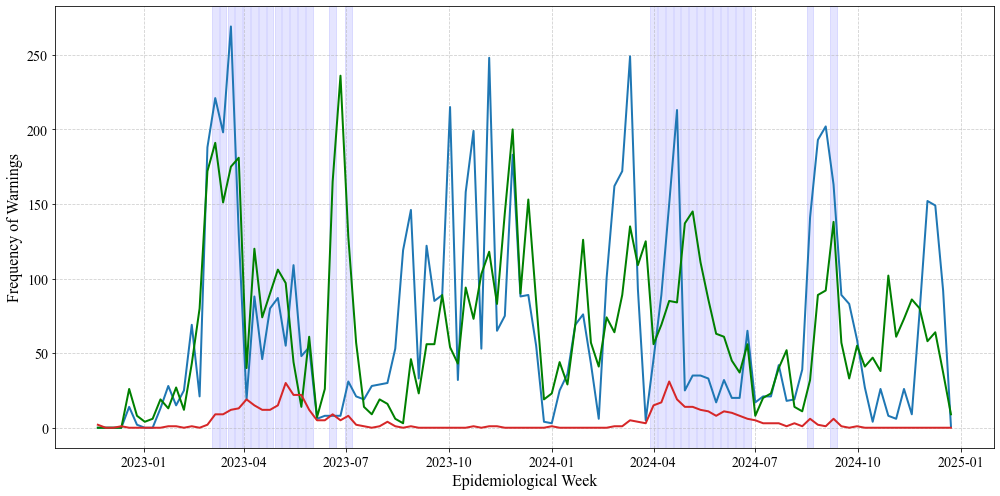

In [39]:
# Define column for AIH warnings
col_aih = 'warning_final_aih'

# Convert date column to datetime
dates = pd.to_datetime(res2['year_week_ts'])

# Identify peak warning weeks
highlight_weeks = pd.to_datetime(res2[res2[col_aih] > res2[col_aih].quantile(0.7)]['year_week_ts'])

# Create figure
plt.figure(figsize=(14, 7))  # Adjust to fit a two-column layout

# Line plots with refined styles
plt.plot(dates, res2['out_of_limits_above_phc_only'], label='Warning PHC', 
         color='#1f77b4', alpha=1, linewidth=2)  # Blue tone

plt.plot(dates, res2['out_of_limits_above_otc_only'], label='Warning OTC', 
         color='green',alpha=1, linewidth=2)  # Orange tone

plt.plot(dates, res2[col_aih], label='Warning Hospitalizations', 
         color='#d62728', linewidth=2)  # Dark red, thicker for emphasis

# Add vertical highlight bands for peak weeks
for week in highlight_weeks:
    plt.axvspan(week - pd.Timedelta(days=3), week + pd.Timedelta(days=3), 
                color='blue', alpha=0.1)  # Subtle highlight

# Format plot with Lancet-style font sizes
plt.xlabel('Epidemiological Week', fontsize=16, fontname='Times New Roman')
plt.ylabel('Frequency of Warnings', fontsize=16, fontname='Times New Roman')

plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')

# Position legend outside the plot for clarity
#plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True, linestyle='--', alpha=0.6)

# Ensure tight layout for publication
plt.tight_layout()

# Show plot
plt.show()


In [40]:
res2[col_aih].quantile(0.7)

5.0

In [42]:
res2.warning_final_aih.describe()

count    110.000000
mean       4.381818
std        6.640136
min        0.000000
25%        0.000000
50%        1.000000
75%        6.000000
max       31.000000
Name: warning_final_aih, dtype: float64

In [43]:
dta_save = res2.rename(columns={'out_of_limits_above_phc_only':'sinal_aps', 'out_of_limits_above_otc_only':'sinal_otc',
                    'warning_final_aih': 'sinal_aih'})

In [44]:
dta_save[['year_week', 'year_week_ts', 'sinal_aps', 'sinal_aih',
       'sinal_otc']].to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/dado_fig3_para_suplementar.csv')

In [45]:
test = res2.groupby(['year_week', 'year_week_ts'])[['out_of_limits_above_phc_only','out_of_limits_above_otc_only','warning_final_aih']].sum().reset_index()

In [46]:
test = test.assign(mes = test.year_week_ts.astype(str).str[5:7])

In [47]:
test.groupby(['mes'])[['out_of_limits_above_phc_only','out_of_limits_above_otc_only','warning_final_aih']].sum().reset_index()



,mes,out_of_limits_above_phc_only,out_of_limits_above_otc_only,warning_final_aih
0,01,265,360,3
1,02,614,543,4
2,03,1337,1156,56
3,04,756,755,154
4,05,473,727,146
5,06,167,633,59
6,07,247,370,27
7,08,740,217,18
8,09,925,599,9
9,10,722,595,1


In [48]:
#test[30:50]

# Counting antecipations

In [49]:
def antici_count(data_res, col_warn_s1, col_warn_s2, col_code):
    """
    Function to compute anticipated counts of warnings and missed warnings 
    across different lead times per unique region.
    
    Parameters:
    data_res (pd.DataFrame): Input DataFrame.
    col_warn_s1 (str): Column name for the primary warning signal (e.g., PHC warnings).
    col_warn_s2 (str): Column name for the secondary warning signal (e.g., AIH warnings).
    col_code (str): Column name identifying the region.

    Returns:
    pd.DataFrame: Summary DataFrame with counts of early, concurrent, and missed warnings.
    """
    
    lst_count = []

    for code in data_res[col_code].unique():
    
        dta = data_res[data_res[col_code] == code].copy()  # Use only data for the current region

        # Find sets based on PHC warnings (col_warn_s1) and AIH warnings (col_warn_s2) at different lags
        set3 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 1)].index + 3
        set2 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 0) & (dta[col_warn_s2].shift(-2) == 1)].index + 2
        set1 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 1)].index + 1
        set0 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 0)].index
        
        # Identify True Negatives (TN)
        set_tn1 = dta[(dta[col_warn_s2] == 0) &  # AIH warning is 0
                      (dta[col_warn_s1] == 0) & 
                      (dta[col_warn_s1].shift(1).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(3).fillna(0) == 0)
                    ].index
        
        set_fp1 = dta[(dta[col_warn_s2] == 0) & 
                   ((dta[col_warn_s1] == 1) | 
                   (dta[col_warn_s1].shift(3).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(2).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(1).fillna(0) == 1))].index

        # Warnings in PHC right after an AIH warning (possibly not anticipated but concurrent)
        set1_after = dta[(dta[col_warn_s1].shift(-1) == 1) & (dta[col_warn_s2] == 1)].index
        
       

        # Compute counts of warnings at different lead times
        n3 = len(set3)
        n2 = len(set(set2) - set(set3))
        n1 = len((set(set1) - set(set3)) - set(set2))
        n0 = len(((set(set0) - set(set3)) - set(set2)) - set(set1))
        n1_after = len((((set(set1_after) - set(set3)) - set(set2)) - set(set1)) - set(set0))
        n_tn1 = len(set_tn1) 
        n_fp1 = len(set_fp1)

        # Drop all anticipated and concurrent warnings to count missed ones
        ind_drop = set(set3) | set(set2) | set(set1) | set(set0) #| set(set1_after)
        missed = dta.drop(index=ind_drop)[col_warn_s2].sum()
        
        TP = n3 + n2 + n1 + n0
        
        # outra forma de calcular o FN
        #set_FN = dta[(dta[col_warn_s2] == 1) &  
        #           (dta[col_warn_s1] == 0) & 
        #           (dta[col_warn_s1].shift(3).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(1).fillna(0) == 0)].index
        
        
        # Create the results dictionary for this region
        data = {
            col_code: [code],
            'n3': [n3],
            'n2': [n2],
            'n1': [n1],
            'n0': [n0],
            'n1_after': [n1_after],
            'missed': [missed],
            'TP': [TP],
            'TN1': [n_tn1], # True Negative
            'FP1': [n_fp1], # False Positive
            'FN': missed,
            'total_aih_warning': [dta[col_warn_s2].sum()]
        }

        # Append to results list
        data_output = pd.DataFrame(data)
        lst_count.append(data_output)

    # Combine all results into a single DataFrame
    df_warning_count = pd.concat(lst_count, ignore_index=True)
    
    return df_warning_count


In [50]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

### APS e AIH

In [51]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')


In [52]:
df_warning_count.to_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_aps_aih_def2.parquet')

In [53]:
def summarize_performance(df_warning_count):
    """
    Summarizes performance metrics including Sensitivity, Specificity, PPV, F1-score, POD, and FPR.
    
    Parameters:
    df_warning_count (pd.DataFrame): Dataframe containing warning counts and classification metrics.
    
    Returns:
    pd.DataFrame: Summary table with performance metrics.
    """
    # Total AIH Warnings
    total_warnings = df_warning_count.total_aih_warning.sum()
    
    # Early Detection (1 to 3 weeks)
    early_count = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum()
    early_rate = round((early_count * 100) / total_warnings, 1)
    
    # Timely Detection (0 week)
    timely_count = df_warning_count.n0.sum()
    timely_rate = round((timely_count * 100) / total_warnings, 1)
    
    # Missed Warnings
    missed_count = df_warning_count.missed.sum()
    missed_rate = round((missed_count * 100) / total_warnings, 1)
    
    # Classification Metrics
    TP = df_warning_count.TP.sum()
    FN = df_warning_count.FN.sum()
    TN = df_warning_count.TN1.sum()
    FP = df_warning_count.FP1.sum()

    
    # Sensitivity (Recall)
    Sensitivity = round((TP / (TP + FN)) * 100, 1) if (TP + FN) > 0 else 0
    
    # Specificity
    Specificity = round((TN / (TN + FP)) * 100, 1) if (TN + FP) > 0 else 0
    
    # Positive Predictive Value (PPV)
    PPV = round((TP / (TP + FP)) * 100, 1) if (TP + FP) > 0 else 0
    
    # F1-score
    F1_score = round(2 * (TP / (TP + FN)) * (TP / (TP + FP)) / ((TP / (TP + FN)) + (TP / (TP + FP))), 2) if ((TP / (TP + FN)) + (TP / (TP + FP))) > 0 else 0
    
    Precision = round(((TP + TN) / (TP + TN + FP + FN) * 100), 1) if (TP + TN + FP + FN) > 0 else 0

    # Probability of Detection (POD)
    POD = round(((early_count + timely_count + df_warning_count.n1_after.sum()) / total_warnings) * 100, 1)
    
    # False Positive Rate (FPR)
    FPR = round((FP / (FP + TN)) * 100, 1) if (FP + TN) > 0 else 0
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        "Metric": ["Total Warnings", "Early Detection (1-3 weeks)", "Timely Detection (0 weeks)", "Missed Warnings",
                   "Sensitivity ", "Specificity", "PPV",  "POD", "FPR","Precision (%)"],
        "Value": [total_warnings, f"{early_count} ({early_rate}%)", f"{timely_count} ({timely_rate}%)", f"{missed_count} ({missed_rate}%)",
                   f"{Sensitivity}%", f"{Specificity}%", f"{PPV}%", f"{POD}%", f"{FPR}%", f"{Precision}%"]
    })
    
    return summary_df



In [54]:
performance_summary = summarize_performance(df_warning_count)


In [55]:
performance_summary

,Metric,Value
0,Total Warnings,482
1,Early Detection (1-3 weeks),271 (56.2%)
2,Timely Detection (0 weeks),42 (8.7%)
3,Missed Warnings,169 (35.1%)
4,Sensitivity,64.9%
5,Specificity,52.7%
6,PPV,2.1%
7,POD,70.1%
8,FPR,47.3%
9,Precision (%),52.8%


### OTC and AIH

In [56]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')

In [57]:
df_warning_count

,co_imed,n3,n2,n1,n0,n1_after,missed,TP,TN1,FP1,FN,total_aih_warning
0,120003,0,0,0,1,1,1,1,50,58,1,2
1,120004,1,1,0,0,1,1,2,63,44,1,3
2,270002,0,0,0,1,0,0,1,48,59,0,1
3,160002,2,0,0,0,0,0,2,57,51,0,2
4,160004,1,0,1,0,0,0,2,46,56,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
284,140002,1,0,1,0,0,0,2,34,71,0,2
285,430014,0,0,0,0,0,2,0,56,47,2,2
286,420014,0,0,0,0,0,1,0,51,52,1,1
287,350039,1,0,0,0,1,1,1,45,63,1,2


In [58]:
df_warning_count.to_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_otc_aih_def2.parquet')

In [59]:
performance_summary = summarize_performance(df_warning_count)


In [60]:
performance_summary

,Metric,Value
0,Total Warnings,482
1,Early Detection (1-3 weeks),296 (61.4%)
2,Timely Detection (0 weeks),30 (6.2%)
3,Missed Warnings,156 (32.4%)
4,Sensitivity,67.6%
5,Specificity,48.5%
6,PPV,2.0%
7,POD,75.9%
8,FPR,51.5%
9,Precision (%),48.8%


## OTC and APS

In [61]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'out_of_limits_above_phc_only', 'co_imed')

In [62]:
performance_summary = summarize_performance(df_warning_count)


In [63]:
performance_summary

,Metric,Value
0,Total Warnings,7550
1,Early Detection (1-3 weeks),2625 (34.8%)
2,Timely Detection (0 weeks),214 (2.8%)
3,Missed Warnings,4711 (62.4%)
4,Sensitivity,37.6%
5,Specificity,52.6%
6,PPV,19.9%
7,POD,61.4%
8,FPR,47.4%
9,Precision (%),49.1%


# APS and OTC

In [64]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'out_of_limits_above_otc_only', 'co_imed')

In [65]:
performance_summary = summarize_performance(df_warning_count)


In [66]:
performance_summary

,Metric,Value
0,Total Warnings,7319
1,Early Detection (1-3 weeks),2939 (40.2%)
2,Timely Detection (0 weeks),150 (2.0%)
3,Missed Warnings,4230 (57.8%)
4,Sensitivity,42.2%
5,Specificity,57.4%
6,PPV,23.0%
7,POD,62.6%
8,FPR,42.6%
9,Precision (%),53.9%


# Study peformance by macro region and pop size

In [67]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [68]:
# Read dictionary with municipalities
df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')
df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')


In [69]:
df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]


df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()



In [70]:
# Dictionary mapping Brazilian states to their regions
state_to_region = {
    "AC": "North", "AM": "North", "AP": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
    "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
    "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
    "DF": "Center-West", "GO": "Center-West", "MT": "Center-West", "MS": "Center-West",
    "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
    "PR": "South", "RS": "South", "SC": "South"
}


result2 = result.merge(df_codes_imed, on='co_imed', how='left')

# Create a new column 'region' by mapping state codes to regions
result2["region"] = result2["Uf"].map(state_to_region)


## Calculate peformance by Macro region

### APS e AIH

In [71]:
# Define macro-regions
macro_regions = result2['region'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.region == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [72]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,112,North
1,Early Detection (1-3 weeks),60 (53.6%),North
2,Timely Detection (0 weeks),9 (8.0%),North
3,Missed Warnings,43 (38.4%),North
4,Sensitivity,61.6%,North
5,Specificity,50.4%,North
6,PPV,2.3%,North
7,POD,71.4%,North
8,FPR,49.6%,North
9,Precision (%),50.6%,North


In [73]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,161,Northeast
1,Early Detection (1-3 weeks),83 (51.6%),Northeast
2,Timely Detection (0 weeks),12 (7.5%),Northeast
3,Missed Warnings,66 (41.0%),Northeast
4,Sensitivity,59.0%,Northeast
5,Specificity,52.6%,Northeast
6,PPV,1.8%,Northeast
7,POD,60.9%,Northeast
8,FPR,47.4%,Northeast
9,Precision (%),52.7%,Northeast


In [74]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,64,Center-West
1,Early Detection (1-3 weeks),44 (68.8%),Center-West
2,Timely Detection (0 weeks),7 (10.9%),Center-West
3,Missed Warnings,13 (20.3%),Center-West
4,Sensitivity,79.7%,Center-West
5,Specificity,54.7%,Center-West
6,PPV,2.5%,Center-West
7,POD,85.9%,Center-West
8,FPR,45.3%,Center-West
9,Precision (%),55.0%,Center-West


In [75]:
performance_results[3]

,Metric,Value,Region
0,Total Warnings,70,Southeast
1,Early Detection (1-3 weeks),41 (58.6%),Southeast
2,Timely Detection (0 weeks),9 (12.9%),Southeast
3,Missed Warnings,20 (28.6%),Southeast
4,Sensitivity,71.4%,Southeast
5,Specificity,52.7%,Southeast
6,PPV,2.0%,Southeast
7,POD,75.7%,Southeast
8,FPR,47.3%,Southeast
9,Precision (%),53.0%,Southeast


In [76]:
performance_results[4]

,Metric,Value,Region
0,Total Warnings,75,South
1,Early Detection (1-3 weeks),43 (57.3%),South
2,Timely Detection (0 weeks),5 (6.7%),South
3,Missed Warnings,27 (36.0%),South
4,Sensitivity,64.0%,South
5,Specificity,53.7%,South
6,PPV,2.0%,South
7,POD,69.3%,South
8,FPR,46.3%,South
9,Precision (%),53.8%,South


### OTC and AIH

In [77]:
# Define macro-regions
macro_regions = result2['region'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.region == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [78]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,112,North
1,Early Detection (1-3 weeks),71 (63.4%),North
2,Timely Detection (0 weeks),4 (3.6%),North
3,Missed Warnings,37 (33.0%),North
4,Sensitivity,67.0%,North
5,Specificity,47.7%,North
6,PPV,2.4%,North
7,POD,76.8%,North
8,FPR,52.3%,North
9,Precision (%),48.0%,North


In [79]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,161,Northeast
1,Early Detection (1-3 weeks),100 (62.1%),Northeast
2,Timely Detection (0 weeks),11 (6.8%),Northeast
3,Missed Warnings,50 (31.1%),Northeast
4,Sensitivity,68.9%,Northeast
5,Specificity,49.6%,Northeast
6,PPV,2.0%,Northeast
7,POD,75.8%,Northeast
8,FPR,50.4%,Northeast
9,Precision (%),49.9%,Northeast


In [80]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,64,Center-West
1,Early Detection (1-3 weeks),42 (65.6%),Center-West
2,Timely Detection (0 weeks),4 (6.2%),Center-West
3,Missed Warnings,18 (28.1%),Center-West
4,Sensitivity,71.9%,Center-West
5,Specificity,47.9%,Center-West
6,PPV,2.0%,Center-West
7,POD,84.4%,Center-West
8,FPR,52.1%,Center-West
9,Precision (%),48.2%,Center-West


In [81]:
performance_results[3]

,Metric,Value,Region
0,Total Warnings,70,Southeast
1,Early Detection (1-3 weeks),44 (62.9%),Southeast
2,Timely Detection (0 weeks),5 (7.1%),Southeast
3,Missed Warnings,21 (30.0%),Southeast
4,Sensitivity,70.0%,Southeast
5,Specificity,47.2%,Southeast
6,PPV,1.8%,Southeast
7,POD,80.0%,Southeast
8,FPR,52.8%,Southeast
9,Precision (%),47.5%,Southeast


In [82]:
performance_results[4]

,Metric,Value,Region
0,Total Warnings,75,South
1,Early Detection (1-3 weeks),39 (52.0%),South
2,Timely Detection (0 weeks),6 (8.0%),South
3,Missed Warnings,30 (40.0%),South
4,Sensitivity,60.0%,South
5,Specificity,49.2%,South
6,PPV,1.8%,South
7,POD,64.0%,South
8,FPR,50.8%,South
9,Precision (%),49.4%,South


## Calculate peformance by population size

In [83]:
result2 = result2.rename(columns = {'2022': 'pop'})

In [84]:
bins = [0, 1.177890e+05, 3.247680e+05, float('inf')]
labels = ['Small', 'Medium', 'Large']

result2['pop_cat'] = pd.cut(result2['pop'], bins=bins, labels=labels, right=True)

small <=  1.177890e+05 
1.177890e+05 < medium <= 3.247680e+05 
large > 3.247680e+05 

In [85]:
result2.head()

,co_imed,Nome_imed,year_week,year_week_ts,out_of_limits_above_phc_only,out_of_limits_above_otc_only,warning_final_aih,Nome_UF,UF,Uf,pop,region,pop_cat
0,120003,Sena Madureira,2022-47,2022-11-21,0,0,0,Acre,12,AC,60068,North,Small
1,120003,Sena Madureira,2022-48,2022-11-28,0,0,0,Acre,12,AC,60068,North,Small
2,120003,Sena Madureira,2022-49,2022-12-05,0,0,0,Acre,12,AC,60068,North,Small
3,120003,Sena Madureira,2022-50,2022-12-12,0,0,0,Acre,12,AC,60068,North,Small
4,120003,Sena Madureira,2022-51,2022-12-19,0,0,0,Acre,12,AC,60068,North,Small


### APS e AIH

In [86]:
# Define macro-regions
macro_regions = result2['pop_cat'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.pop_cat == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [87]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,136,Small
1,Early Detection (1-3 weeks),81 (59.6%),Small
2,Timely Detection (0 weeks),9 (6.6%),Small
3,Missed Warnings,46 (33.8%),Small
4,Sensitivity,66.2%,Small
5,Specificity,51.2%,Small
6,PPV,2.0%,Small
7,POD,72.1%,Small
8,FPR,48.8%,Small
9,Precision (%),51.5%,Small


In [88]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,215,Medium
1,Early Detection (1-3 weeks),115 (53.5%),Medium
2,Timely Detection (0 weeks),20 (9.3%),Medium
3,Missed Warnings,80 (37.2%),Medium
4,Sensitivity,62.8%,Medium
5,Specificity,53.0%,Medium
6,PPV,1.9%,Medium
7,POD,67.9%,Medium
8,FPR,47.0%,Medium
9,Precision (%),53.1%,Medium


In [89]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,131,Large
1,Early Detection (1-3 weeks),75 (57.3%),Large
2,Timely Detection (0 weeks),13 (9.9%),Large
3,Missed Warnings,43 (32.8%),Large
4,Sensitivity,67.2%,Large
5,Specificity,53.6%,Large
6,PPV,2.4%,Large
7,POD,71.8%,Large
8,FPR,46.4%,Large
9,Precision (%),53.9%,Large


### OTC and AIH

In [90]:
# Define macro-regions
macro_regions = result2['pop_cat'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.pop_cat == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [91]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,136,Small
1,Early Detection (1-3 weeks),85 (62.5%),Small
2,Timely Detection (0 weeks),10 (7.4%),Small
3,Missed Warnings,41 (30.1%),Small
4,Sensitivity,69.9%,Small
5,Specificity,47.6%,Small
6,PPV,2.0%,Small
7,POD,77.2%,Small
8,FPR,52.4%,Small
9,Precision (%),47.9%,Small


In [92]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,215,Medium
1,Early Detection (1-3 weeks),134 (62.3%),Medium
2,Timely Detection (0 weeks),12 (5.6%),Medium
3,Missed Warnings,69 (32.1%),Medium
4,Sensitivity,67.9%,Medium
5,Specificity,48.6%,Medium
6,PPV,1.9%,Medium
7,POD,77.2%,Medium
8,FPR,51.4%,Medium
9,Precision (%),48.8%,Medium


In [93]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,131,Large
1,Early Detection (1-3 weeks),77 (58.8%),Large
2,Timely Detection (0 weeks),8 (6.1%),Large
3,Missed Warnings,46 (35.1%),Large
4,Sensitivity,64.9%,Large
5,Specificity,49.5%,Large
6,PPV,2.1%,Large
7,POD,72.5%,Large
8,FPR,50.5%,Large
9,Precision (%),49.8%,Large
